## Medical Appointment No Shows
Why do 20% of patients miss their scheduled appointments?
Trying to explain most important features and predict no-shows for imbalanced target feature

Source: Kaggle<br>
URL: https://www.kaggle.com/joniarroba/noshowappointments

In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from datetime import timedelta
from scipy import stats
import pprint
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [93]:
Appointments_df = pd.read_csv('KaggleV2-May-2016.csv')

In [94]:
Appointments_df.shape

(110527, 14)

In [95]:
Appointments_df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [96]:
Appointments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Brief look at data

In [97]:
Appointments_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


There are 13 features and 1 target column (No-show).
I assume that PatientId and AppointmentID features do not contain any important information and are assigned to each patient without any pattern.

#### Checking for missing values

In [98]:
np.sum(Appointments_df.isnull())

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

No missing data

#### Summary for numerical data

In [99]:
 Appointments_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


####  Summary for categorical data

In [100]:
Appointments_df.loc[:,Appointments_df.dtypes == 'object'].describe()

,Gender,ScheduledDay,AppointmentDay,Neighbourhood,No-show
count,110527,110527,110527,110527,110527
unique,2,103549,27,81,2
top,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,JARDIM CAMBURI,No
freq,71840,24,4692,7717,88208


#### Encoding Gender: F= 0 M = 1
It is needed for model preparation

In [101]:
Appointments_df.loc[Appointments_df['Gender'] == 'F','Gender'] = 0
Appointments_df.loc[Appointments_df['Gender'] == 'M','Gender'] = 1
Appointments_df['Gender'] = Appointments_df['Gender'].astype(int)

#### Encoding No-shows: Yes = 1 No = 0 (different approach to encoding: useful when dealing with more categories)

In [102]:
def encoder(Series):
    return {val: key for key, val in enumerate(Series.unique())}

In [103]:
enc = encoder(Appointments_df['No-show'])
print(enc)

{'No': 0, 'Yes': 1}


In [104]:
Appointments_df['No-show'] = Appointments_df['No-show'].map(enc)

In [105]:
Appointments_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


#### Converting dates from str format to datetime format 

In [106]:
Appointments_df['ScheduledDay'] = pd.to_datetime(Appointments_df['ScheduledDay'])
Appointments_df['ScheduledDay'] = Appointments_df['ScheduledDay'].values.astype('datetime64[D]') #to get only days as in AppointmentDay
Appointments_df['AppointmentDay'] = pd.to_datetime(Appointments_df['AppointmentDay'])

### Adding feature: diff between scheduled date and appointment date
Intuitively it might be useful to see the timespan from schedule to appointment vs. no-show ratio

In [107]:
Appointments_df['Schedule_to_Appointment'] = Appointments_df['AppointmentDay'] - Appointments_df['ScheduledDay']
Appointments_df['Schedule_to_Appointment'] = Appointments_df['Schedule_to_Appointment'].dt.days #get days as integers

#### Schedule_to_Appointment variable analysis

In [108]:
Appointments_df.groupby('No-show')['Schedule_to_Appointment'].describe()

,count,mean,std,min,25%,50%,75%,max
No-show,,,,,,,,
0,88208.0,8.754659,14.550398,0.0,0.0,2.0,12.0,179.0
1,22319.0,15.831489,16.605912,-6.0,4.0,11.0,23.0,179.0


There should not be any negative differences between Appointment and Schedule dates. Let's check entries with negative values

In [109]:
mask = Appointments_df['Schedule_to_Appointment'] < 0
Appointments_df[mask]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Schedule_to_Appointment
27033,7.839273e+12,5679978,1,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,1,-1
55226,7.896294e+12,5715660,0,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,-1
64175,2.425226e+13,5664962,0,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,1,-1
71533,9.982316e+14,5686628,0,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,-6
72362,3.787482e+12,5655637,1,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,1,-1


There are only 5 entires with negative values - I assume they are errors and I will delete them:

In [110]:
Appointments_df = Appointments_df.loc[mask==False,:]

In [111]:
pd.crosstab(Appointments_df['Schedule_to_Appointment'].values, columns ='count', normalize = True).head()

col_0,count
row_0,
0,0.348917
1,0.047167
2,0.060848
3,0.024764
4,0.047864


Now it is ok: diffs start from 0

##### Looking at diffs distribution

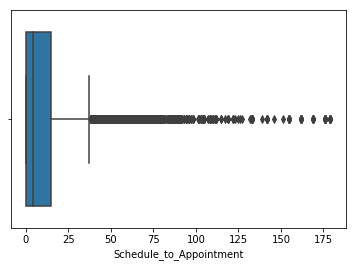

In [112]:
sns.boxplot(Appointments_df['Schedule_to_Appointment'])
plt.show()

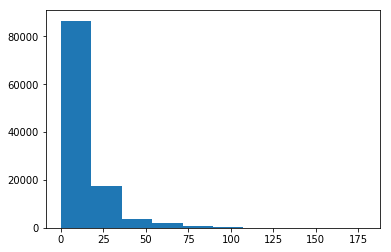

In [113]:
plt.hist(Appointments_df['Schedule_to_Appointment'])
plt.show()

Many visits (35%) were scheduled same day as appointment (diff == 0), as we can see the distribution is highly right skewed, max waiting time was round 175 days. There are no outliers that look as errors. 

#### Transforming feature

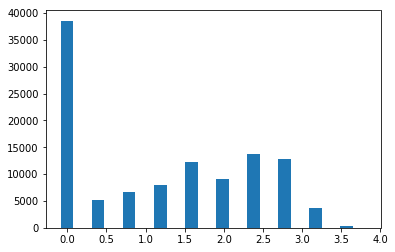

In [114]:
plt.hist(stats.boxcox(Appointments_df['Schedule_to_Appointment']+1))
plt.show()

Still not satisfatiory, I will try to discretize feature accordingly with percentiles:

In [115]:
schedule_to_appointment_cut = pd.qcut(Appointments_df['Schedule_to_Appointment'],q=5,duplicates = 'drop')

In [116]:
pd.crosstab(schedule_to_appointment_cut,columns = 'count',normalize = True)

col_0,count
Schedule_to_Appointment,
"(-0.001, 2.0]",0.456932
"(2.0, 7.0]",0.183194
"(7.0, 19.0]",0.161515
"(19.0, 179.0]",0.198359


Generating crosstab to see the distribution of no-shows vs. time group to appointment 

In [117]:
Schdl_to_Apntm_cross =pd.crosstab(schedule_to_appointment_cut, Appointments_df['No-show'])
Schdl_to_Apntm_cross

No-show,0,1
Schedule_to_Appointment,,
"(-0.001, 2.0]",45994,4507
"(2.0, 7.0]",15190,5057
"(7.0, 19.0]",12309,5542
"(19.0, 179.0]",14715,7208


#### Let's run hypothesis test of independence of the observed frequencies in the contingency table
Namely let's see whether no. of no-shows is dependent on time between schedule to appointment

In [118]:
chi2, p, dof, ex = stats.chi2_contingency(Schdl_to_Apntm_cross)

results = pd.Series()

results['CHI2_stat'] = chi2
results['p-value'] = p
results

CHI2_stat    7761.45822
p-value         0.00000
dtype: float64

As we can see, we have to reject H0, so the variable Schedule_to_Appointment and No-show are not indepentent (there is relation between number of days between schedule and appointment and number of no-shows).

This variable looks promising and might be usefull to predict no-shows. But now let's continue this analysis

#### Let's look at AppointmentDay dates

In [119]:
Appointments_df.groupby([Appointments_df['AppointmentDay'].dt.year,Appointments_df['AppointmentDay'].dt.month]).size()

AppointmentDay  AppointmentDay
2016            4                  3235
                5                 80836
                6                 26451
dtype: int64

Appointments dates are only from 3 months of the year 2016 (it might hipotetically affect the number of no-shows (for example because of weather: in Brasil it is winter) - we will need to be very cautious when trying to generalize results of this particular analysis.

But now let's continue, I will analyse target varaible distribution and binary features (see whether they are highly imbalanced and visualize some of them):

### Target variable

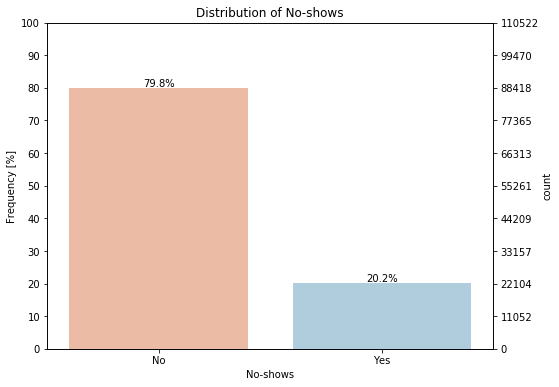

In [120]:
ncount = len(Appointments_df)
plt.figure(figsize=(8,6))
ax = sns.countplot(x="No-show", data=Appointments_df,palette='RdBu')
plt.title('Distribution of No-shows')
plt.xlabel('No-shows')
x_ticks_labels=['No', 'Yes']
ax.set_xticklabels(x_ticks_labels)

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.grid(False)

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(False)
plt.show()

In total 20,2% of all observations constitue no-show patients. The target is imbalanced. I will need to have it in mind while preparing a model.

### Gender, Scholarship, Hipertension, Diabetes, Alcoholism and SMS_received variables

Chosing binary columns automatically

In [121]:
binary_cols = [col for col in Appointments_df.columns if np.isin(Appointments_df[col].unique(),[0,1]).all()]
binary_cols = binary_cols[:-1] #getting rid of the no-show column

In [122]:
def get_pivot_tabs(df,binary_cols):
    pivot_tab = {}
    for idx, col in enumerate(binary_cols):
        df = pd.pivot_table(Appointments_df,index = col, values = 'No-show',aggfunc = [np.mean, np.sum, np.size])
        df.columns = ['%No-shows','Num No-shows', 'Observations']
        pivot_tab[col] = df
    return pivot_tab

In [123]:
pivots = get_pivot_tabs(Appointments_df,binary_cols)

for tab in pivots.values():
    pprint.pprint(tab)  
    print('\n-------------------------------------------------------------')
    print('-------------------------------------------------------------\n')

        %No-shows  Num No-shows  Observations
Gender                                       
0        0.203113         14591         71837
1        0.199638          7723         38685

-------------------------------------------------------------
-------------------------------------------------------------

             %No-shows  Num No-shows  Observations
Scholarship                                       
0             0.198031         19736         99661
1             0.237363          2578         10861

-------------------------------------------------------------
-------------------------------------------------------------

              %No-shows  Num No-shows  Observations
Hipertension                                       
0              0.208992         18542         88721
1              0.173020          3772         21801

-------------------------------------------------------------
-------------------------------------------------------------

          %No-shows  Num N

#### Visualization

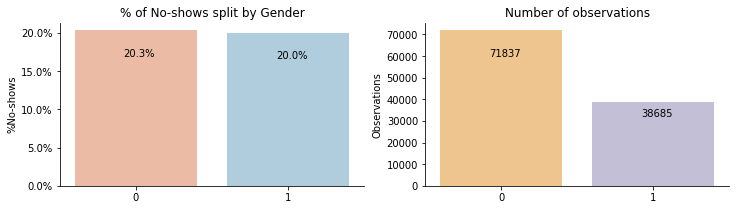


        %No-shows  Num No-shows  Observations
Gender                                       
0        0.203113         14591         71837
1        0.199638          7723         38685
-------------------------------------------------------------------------------------------------------------



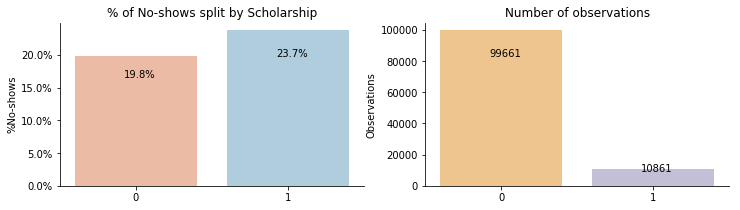


             %No-shows  Num No-shows  Observations
Scholarship                                       
0             0.198031         19736         99661
1             0.237363          2578         10861
-------------------------------------------------------------------------------------------------------------



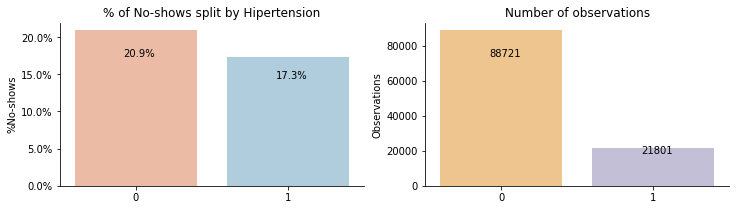


              %No-shows  Num No-shows  Observations
Hipertension                                       
0              0.208992         18542         88721
1              0.173020          3772         21801
-------------------------------------------------------------------------------------------------------------



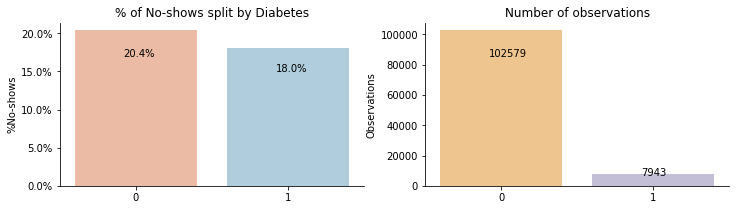


          %No-shows  Num No-shows  Observations
Diabetes                                       
0          0.203589         20884        102579
1          0.180033          1430          7943
-------------------------------------------------------------------------------------------------------------



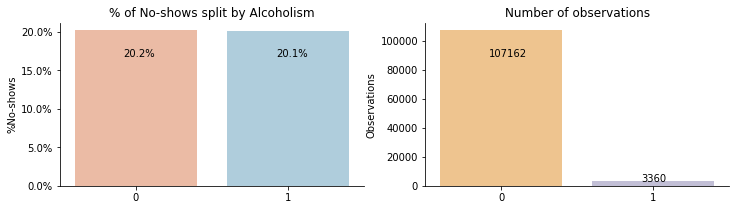


            %No-shows  Num No-shows  Observations
Alcoholism                                       
0            0.201909         21637        107162
1            0.201488           677          3360
-------------------------------------------------------------------------------------------------------------



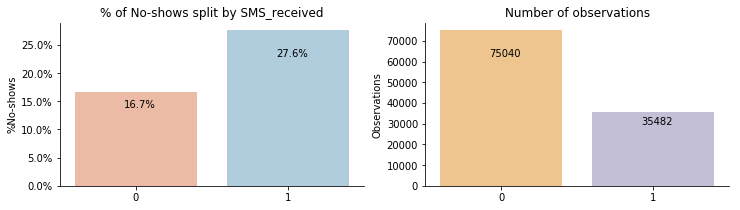


              %No-shows  Num No-shows  Observations
SMS_received                                       
0              0.166978         12530         75040
1              0.275745          9784         35482
-------------------------------------------------------------------------------------------------------------



In [124]:
for key in pivots.keys():
    
    fig, ax = plt.subplots(1,2,figsize =(12,3))

    sns.barplot(x = ['0','1'], y = pivots[key].loc[:,'%No-shows'],palette='RdBu', ax = ax[0])
    for p in ax[0].patches:
        ax[0].annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+p.get_width()/2.5, p.get_height()/1.2))
    ax[0].set_title('% of No-shows split by '+key)
    ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

    sns.barplot(x = ['0','1'], y = pivots[key].loc[:,'Observations'],palette='PuOr', ax = ax[1])
    for p in ax[1].patches:
        ax[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2.5, p.get_height()/1.2))
    ax[1].set_title('Number of observations')

    sns.despine()
    plt.show()
    
    print('')
    pprint.pprint(pivots[key])
    print('-------------------------------------------------------------------------------------------------------------')
    print('')

##### Key interesting facts:

* There were much more woman than man in the sample (it may indicate that they do use healthcare services more often than man)
* People that were part of Scholarship tended to omit appointments more often (by 3.9 percentage points)
* People with diabetes or hipertension tended to come to visits more often
* Information behind SMS received is counterintuitive: Out of those who have received SMS 27.6% did not come to visit, which is much more than people who did not receive SMS and did not come to visit (fraction of 16.7%). Maybe SMS received means sth different than remainder about an upcoming visit.


### Age variable

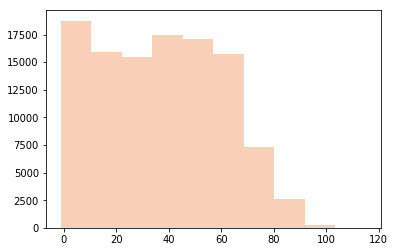

In [125]:
plt.hist(Appointments_df['Age'], color = '#f9cfb8')
plt.show()

#### Age vs no-shows

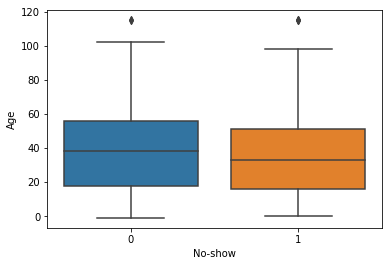

In [126]:
sns.boxplot(Appointments_df['No-show'],Appointments_df['Age'])
plt.show()

Distribution of Age variable when separated into people who went to visit and those who did not show up to their appointments. As we can see there is a slight difference of age for show-up and no-shows (there are more young people that miss their visits).<br>
I will also discretize this variable and present no-show rate by each age group: 

In [127]:
age_cut = pd.qcut(Appointments_df['Age'],5)
age_show_cross = pd.crosstab(age_cut,Appointments_df['No-show'],normalize = 'index')
age_show_cross

No-show,0,1
Age,,
"(-1.001, 13.0]",0.791815,0.208185
"(13.0, 30.0]",0.749766,0.250234
"(30.0, 45.0]",0.786316,0.213684
"(45.0, 59.0]",0.821068,0.178932
"(59.0, 115.0]",0.846920,0.153080


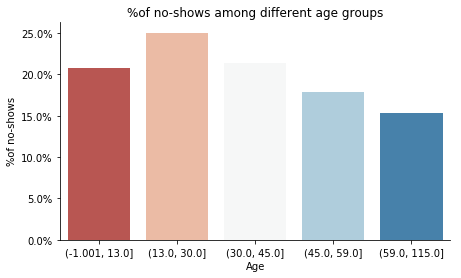

In [128]:
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(age_show_cross.index,age_show_cross[1],palette='RdBu',ax=ax)
ax.set_title('%of no-shows among different age groups')
ax.set_ylabel('%of no-shows')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
sns.despine()
plt.show()

There is non-linear relationship between age and no-show rate: people in rage 13-30 years old miss their appointments most often, both people in lower and higher age groups show-up to their appointments more often.

Checking, whether difference is statistically significant using spearmann corr:

In [129]:
corr, p_val = stats.spearmanr(Appointments_df['Age'],Appointments_df['No-show'])

print('Spearman rank corr equals: {0:.3f}'.format(corr))
print('P-value equals: {0:.5f}'.format(p_val))

Spearman rank corr equals: -0.061
P-value equals: 0.00000


There is statistically significant negative correlation between age and no-shows at the level of -0.06.
It means that the older the person the lower is the chance of no-show

### Handicap variable

In [130]:
Appointments_df['Handcap'].value_counts()

0    108283
1      2040
2       183
3        13
4         3
Name: Handcap, dtype: int64

I will group 2,3,4 categories into one, because of very low number of observations in groups 3 and 4

In [131]:
more_two = (Appointments_df['Handcap'] == 3) | (Appointments_df['Handcap'] == 4)
Appointments_df.loc[more_two,'Handcap'] = 2

After grouping:

In [132]:
Appointments_df['Handcap'].value_counts()

0    108283
1      2040
2       199
Name: Handcap, dtype: int64

In [133]:
handcap_show_cross = pd.crosstab(Appointments_df['Handcap'],Appointments_df['No-show'], normalize='index')
handcap_show_cross

No-show,0,1
Handcap,,
0,0.797669,0.202331
1,0.821569,0.178431
2,0.793970,0.206030


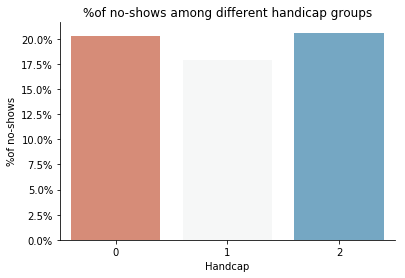

In [134]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(handcap_show_cross.index,handcap_show_cross[1],palette='RdBu',ax=ax)
ax.set_title('%of no-shows among different handicap groups')
ax.set_ylabel('%of no-shows')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
sns.despine()
plt.show()

### Neighbourhood variable

In [135]:
Appointments_df['Neighbourhood'].unique()

array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

In [136]:
'There are {} neighbourhoods.'.format(len(Appointments_df['Neighbourhood'].unique()))

'There are 81 neighbourhoods.'

Let's see neighbourhoods with lowest number of observations:

In [137]:
Appointments_df['Neighbourhood'].value_counts().tail(20)

MÁRIO CYPRESTE                 371
BOA VISTA                      312
COMDUSA                        310
DE LOURDES                     305
ARIOVALDO FAVALESSA            282
ANTÔNIO HONÓRIO                271
FRADINHOS                      258
ENSEADA DO SUÁ                 235
SANTA HELENA                   178
HORTO                          175
UNIVERSITÁRIO                  152
SEGURANÇA DO LAR               145
NAZARETH                       135
MORADA DE CAMBURI               96
PONTAL DE CAMBURI               69
ILHA DO BOI                     35
ILHA DO FRADE                   10
AEROPORTO                        8
ILHAS OCEÂNICAS DE TRINDADE      2
PARQUE INDUSTRIAL                1
Name: Neighbourhood, dtype: int64

I will not visualize data for cities/villages with less than 200 observations

In [138]:
Neighbourhood_count = Appointments_df['Neighbourhood'].value_counts()
Neighbourhood_count_200 = Neighbourhood_count[Neighbourhood_count> 200]

Neighbourhood_200_df = Appointments_df[Appointments_df['Neighbourhood'].isin(Neighbourhood_count_200.index)]

Different approach to filtering:

In [139]:
Neighbourhood_200_df_v2 = Appointments_df.groupby('Neighbourhood').filter(lambda x: len(x) > 200)

In [140]:
neighbourhood_show_cross = pd.crosstab(Neighbourhood_200_df_v2['Neighbourhood'],Neighbourhood_200_df_v2['No-show'], normalize ='index')
neighbourhood_show_cross = neighbourhood_show_cross.sort_values(0)

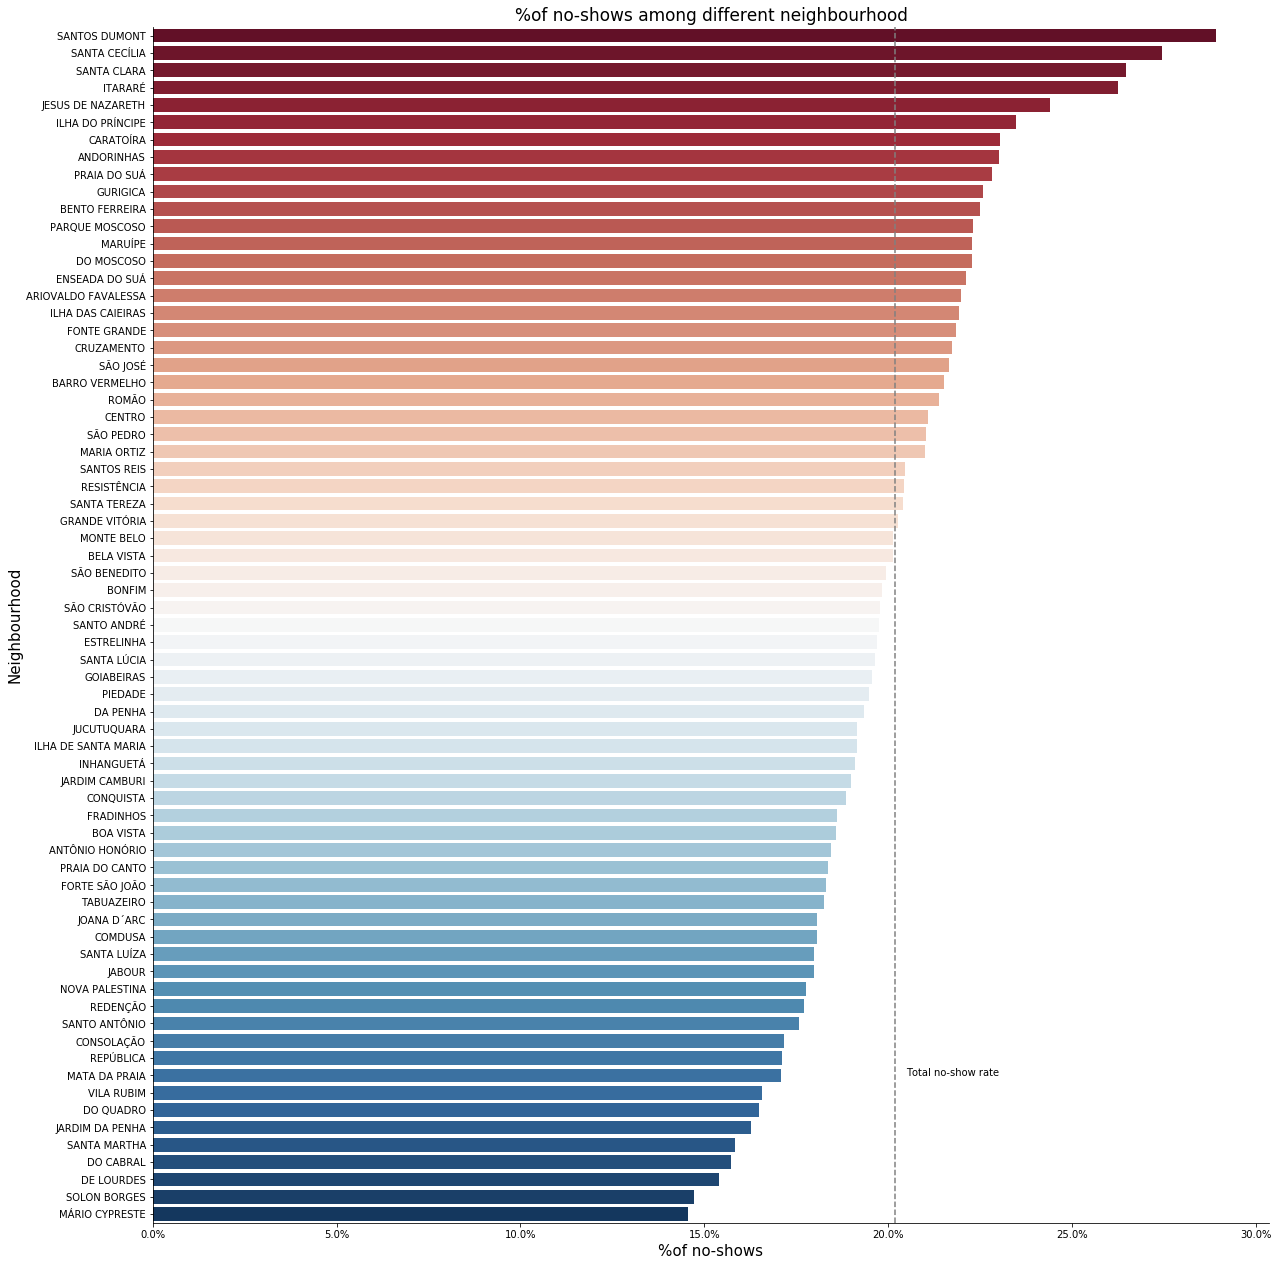

In [141]:
fig, ax = plt.subplots(figsize=(20,22))
sns.barplot(y = neighbourhood_show_cross.index, x= neighbourhood_show_cross[1],palette='RdBu',ax=ax)
ax.set_title('%of no-shows among different neighbourhood', fontsize = 17)
ax.set_xlabel('%of no-shows', fontsize = 15)
ax.set_ylabel('Neighbourhood', fontsize = 15)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.axvline(x=sum(Appointments_df['No-show']==1)/len(Appointments_df),linestyle= '--',color = 'grey')
plt.text(x=0.205,y=60,s='Total no-show rate')
#plt.xticks([])
sns.despine()
plt.show()

There are 81 neighbourhoods, I can use them for modeling separately or group into categories using Decision Tree thresholds (setting max depth to 3 nodes). I will use both approaches to check differences.

Encoding neighbourhood:<br> 
first step (sorting values by %no-show for each neighbourhood group)

In [142]:
Neighbourhood_grp_sorted = pd.DataFrame(Appointments_df.groupby('Neighbourhood')['No-show'].mean().sort_values())
Neighbourhood_grp_sorted.columns = ['%no-show_neigh']
Neighbourhood_grp_sorted.head()

,%no-show_neigh
Neighbourhood,
PARQUE INDUSTRIAL,0.000000
ILHA DO BOI,0.085714
AEROPORTO,0.125000
MÁRIO CYPRESTE,0.145553
SOLON BORGES,0.147122


In [143]:
Appointments_df_neigh = pd.merge(Appointments_df, Neighbourhood_grp_sorted, left_on = 'Neighbourhood', right_index= True)
Appointments_df_neigh.sort_values('%no-show_neigh',inplace = True)

Using custom function 'encoder' to encode neighbourhood to numerical value (after sorting, the higher is the number the higher is the no-show ratio)

In [144]:
neighbourhood_enc = Appointments_df_neigh.loc[:,'Neighbourhood'].map(encoder(Appointments_df_neigh['Neighbourhood']))

In [145]:
Appointments_df_neigh["Neighbourhood"] = neighbourhood_enc

Building Decision Tree to get thresholds to discretize neighbourhood feature

In [146]:
kflod_10 = KFold(n_splits=10, shuffle= True)

In [147]:
scoring = {'F1':'f1', 'ROC':'roc_auc',}

In [148]:
tree_neighbourhoods = GridSearchCV(DecisionTreeClassifier(),
                                   param_grid = {'max_depth':[3]},
                                   cv  = kflod_10,
                                   scoring = scoring,
                                   refit = 'F1')
                                   
tree_neighbourhoods.fit(Appointments_df_neigh['Neighbourhood'].reshape(-1,1), Appointments_df_neigh['No-show'])
#metrics.f1_score(tree_neighbourhoods.predict(Appointments_df_neigh['Neighbourhood'].reshape(-1,1)),Appointments_df_neigh['No-show'])

C:\Python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
C:\Python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', '

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1, param_grid={'max_depth': [3]},
       pre_dispatch='2*n_jobs', refit='F1', return_train_score='warn',
       scoring={'F1': 'f1', 'ROC': 'roc_auc'}, verbose=0)

Printing thresholds and nodes (from sklearn documentation):

In [149]:
estimator = tree_neighbourhoods.best_estimator_
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))


The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 50.5 else to node 8.
	node=1 test node: go to node 2 if X[:, 0] <= 25.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 0] <= 11.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 0] <= 36.5 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 0] <= 74.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 0] <= 63.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 0] <= 77.5 else to node 14.
			node=13 leaf node.
			node=14 leaf node.


In [150]:
set(np.sort(estimator.tree_.threshold))

{-2.0, 11.5, 25.5, 36.5, 50.5, 63.5, 74.5, 77.5}

In [151]:
thresholds = [-0.001,11,25,36,50,63,74,77,81] #from nodes above

In [152]:
neighbourhood_cut = pd.cut(Appointments_df_neigh['Neighbourhood'],bins = thresholds)

neighbourhood_cut will be used at the later stage in building model with grouped neighbourhoods 

### Building model: splitting data on dependent and independent variable and train/test

First I will build model with all catetorical variables ungrouped and binarized, at the later stage I will see whether grouped neighbourhoods will affect model performance. Besides I will try to oversample under-represented class.

In [153]:
X = Appointments_df.drop(['PatientId', 'AppointmentID', 'ScheduledDay','AppointmentDay','No-show'], axis=1)
y = Appointments_df['No-show']

Binarizing all categorical data:

In [154]:
X = pd.get_dummies(X)
X.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Schedule_to_Appointment,Neighbourhood_AEROPORTO,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,0,62,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

----------------------------------------------------------------------------------------------------------------------------

### Random Forrest
Building Random Forrest to predict no-shows

Important notes:<br>
Target is imbalanced<br>
* Using accuracy as an evaluation metric might cause model to choose naive solution i.e. predicting 0 only (reaching at the same time an accuracy of ~80%) - such solution would not add any value. Here I will use other metric that is better for imbalanced target: f-score: weighted avg. of precision and recall (roc_auc would be appropriate choice too) 
* Other way to tackle imbalanced variable is resampling: over-sampling instances from the under-represented class or under-sampling data from over-represented class. This approach will be presented at the later stage.   

In [156]:
## We could use beta = 2 if we want to have higher recall in cost of lower precision: 
ftwo_scorer = metrics.make_scorer(metrics.fbeta_score, beta=2) #high beta for recall oritnted usage/ low beta for precision oriented user

In [158]:
tree = GridSearchCV(RandomForestClassifier(),
                                   param_grid = {'max_depth':[60,80,90],
                                                 'n_estimators':[10,30,40]},
                                   cv  = kflod_10,
                                   scoring = 'f1')
tree.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [60, 80, 90], 'n_estimators': [10, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [159]:
tree.best_params_

{'max_depth': 90, 'n_estimators': 40}

In [160]:
'Best F-score for test set in crossvalidation: {:.3f}'.format(tree.best_score_)

'Best F-score for test set in crossvalidation: 0.282'

#### Evaluation of model performance on test set

In [161]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test,tree.best_estimator_.predict(X_test)))

'Precision: 39.3%'

In [162]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test,tree.best_estimator_.predict(X_test)))

'Recall: 24.0%'

In [163]:
'Accuracy: {:.1%}'.format(metrics.accuracy_score(y_test,tree.best_estimator_.predict(X_test)))

'Accuracy: 77.1%'

In [168]:
print(metrics.classification_report(y_test,tree.best_estimator_.predict(X_test), target_names = ['0','1']))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86     22032
          1       0.39      0.24      0.30      5599

avg / total       0.74      0.77      0.75     27631



In [164]:
conf_tree = metrics.confusion_matrix(y_test,tree.best_estimator_.predict(X_test))
pprint.pprint(conf_tree)

array([[19958,  2074],
       [ 4255,  1344]], dtype=int64)


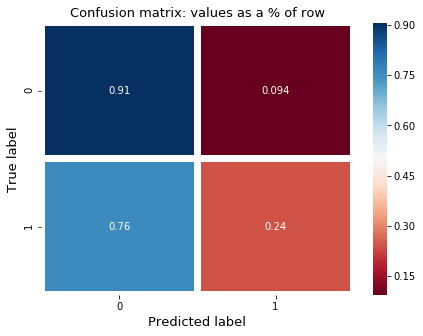

In [165]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_tree/np.sum(conf_tree,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of row',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

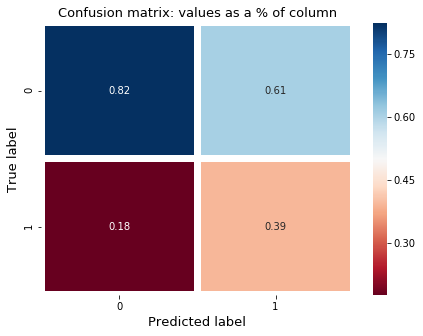

In [166]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_tree/np.sum(conf_tree,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

In [167]:
metrics.roc_auc_score(y_test,tree.best_estimator_.predict_proba(X_test)[:,1])

0.70599481093794236

#### ROC curve

In [169]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree.best_estimator_.predict_proba(X_test)[:,1])

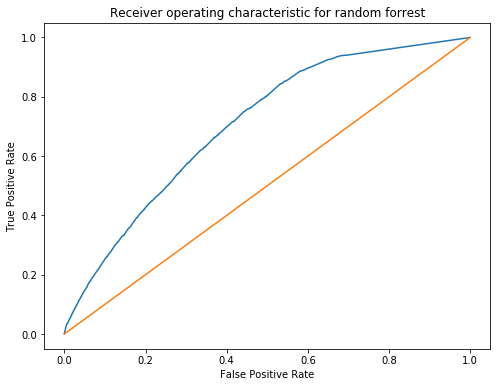

In [170]:
fig, ax =  plt.subplots(figsize = (8,6))
ax.plot(fpr,tpr)
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic for random forrest')
ax.legend(loc="lower right")
plt.show()


#### Let's see the most important features as indicated by Random Forest Classifier.

In [172]:
Feature_importances = pd.Series()
for col, val in zip(X.columns,tree.best_estimator_.feature_importances_):
    Feature_importances[col] = val

pd.options.display.float_format = '{:,.3f}'.format    
Feature_importances.sort_values(ascending = False)

Age                                         0.362
Schedule_to_Appointment                     0.356
Gender                                      0.028
SMS_received                                0.016
Hipertension                                0.011
Diabetes                                    0.008
Scholarship                                 0.008
Handcap                                     0.007
Alcoholism                                  0.006
Neighbourhood_RESISTÊNCIA                   0.005
Neighbourhood_JARDIM CAMBURI                0.005
Neighbourhood_BONFIM                        0.005
Neighbourhood_CENTRO                        0.005
Neighbourhood_SÃO PEDRO                     0.005
Neighbourhood_SANTO ANDRÉ                   0.005
Neighbourhood_DA PENHA                      0.004
Neighbourhood_SÃO JOSÉ                      0.004
Neighbourhood_MARIA ORTIZ                   0.004
Neighbourhood_ROMÃO                         0.004
Neighbourhood_TABUAZEIRO                    0.004


It turns out that almost all variables bring some information about possibility of no-show. Definitely the most important variables are Age and Time from schedule to appointment.

#### Conclusion random forrest:
This model detects 24% of true positives. Precision equals 39%. Random Forrest dealt with imbalanced data well i.e. did not converge to naive solution (predicting only 0 class), which is a good sign. We will see how Logistic Regression and SVC deal with imbalanced data and this particular dataset.

----------------------------------------------------------------------------------------------------------------------------

### Logistic Regression with feature scaling

For Logistic Regression with regularization it is important to standarize features, so they they are on the same scale. Here I use make_pipeline to scale and build logistic regression.: 

In [173]:
log_reg = GridSearchCV(make_pipeline(preprocessing.StandardScaler(),LogisticRegression()),
                        param_grid = {'logisticregression__C':[0.01,0.1,1,5]},
                        cv  = kflod_10,
                        scoring = scoring,
                        refit = 'F1')

log_reg.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 5]},
       pre_dispatch='2*n_jobs', refit='F1', return_train_score='warn',
       scoring={'F1': 'f1', 'ROC': 'roc_auc'}, verbose=0)

In [174]:
log_reg.best_params_

{'logisticregression__C': 1}

In [175]:
'Best score for test set in crossvalidation: {:.3f}'.format(log_reg.best_score_)

'Best score for test set in crossvalidation: 0.028'

#### Evaluation of model performance on test set

In [176]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test,log_reg.best_estimator_.predict(X_test)))

'Precision: 40.7%'

In [177]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test,log_reg.best_estimator_.predict(X_test)))

'Recall: 1.6%'

In [178]:
conf_logreg = metrics.confusion_matrix(y_test,log_reg.best_estimator_.predict(X_test))
pprint.pprint(conf_logreg)

array([[21898,   134],
       [ 5507,    92]], dtype=int64)


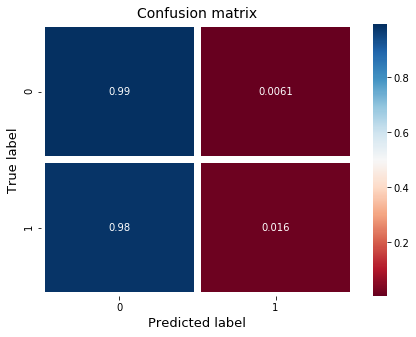

In [179]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix',fontsize = 14)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

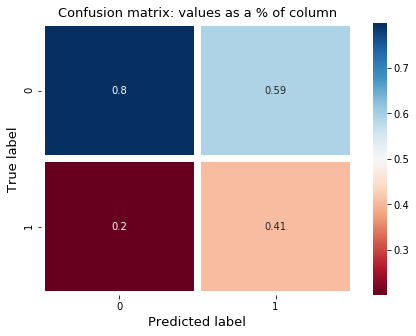

In [180]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

#### Conclusion logistic regression:
This model is very poor when it comes to detecting no-shows. Recall on the level of 1.6% means that 98.4% of true positives are not detected by this model. From confusion matrix we can see that model is very cautious when it comes to predicting positives i.e. it is very close to naive model which assigns 0 to all of the data, which is not a good sign. 

----------------------------------------------------------------------------------------------------------------------------

### Linear SVC and feature scaling

In [113]:
SVC = GridSearchCV(make_pipeline(preprocessing.StandardScaler(),LinearSVC()),
                        param_grid = {'linearsvc__C':[0.01,0.1,1]},
                        cv  = kflod_10,
                        refit = 'recall')

SVC.fit(X_train2,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearsvc__C': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score='warn',
       scoring=None, verbose=0)

In [114]:
SVC.best_params_

{'linearsvc__C': 0.01}

In [115]:
'Best score for test set in crossvalidation: {:.3f}',format(SVC.best_score_)

('Best score for test set in crossvalidation: {:.3f}', '0.7963711380005067')

#### Evaluation of model performance on test set

In [236]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test2,SVC.best_estimator_.predict(X_test2)))

'Precision: 36.9%'

In [235]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test2,SVC.best_estimator_.predict(X_test2)))

'Recall: 0.9%'

In [109]:
conf_SVC = metrics.confusion_matrix(y_test,SVC.best_estimator_.predict(X_test2))
pprint.pprint(conf_SVC)

array([[21950,    82],
       [ 5551,    48]], dtype=int64)


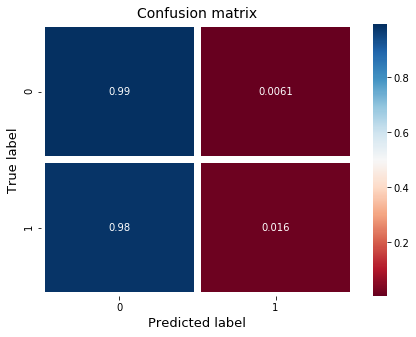

In [110]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix',fontsize = 14)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

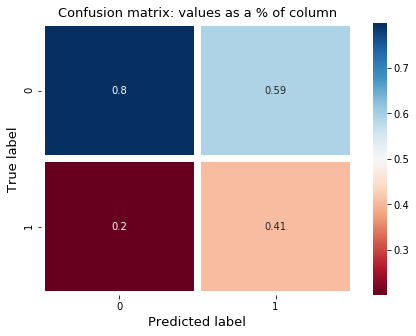

In [111]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

#### Conclusion SVC:
Similarly to logistic regression, SVC is very poor when it comes to detecting no-shows. From confusion matrix we can see that model is very cautious when it comes to predicting positives i.e. it is very close to naive model which assigns 0 to all of the data, which is not a good sign. In fact it is even worse than logistic regression. 

----------------------------------------------------------------------------------------------------------------------------

## Dealing with class imbalance: oversampling under-represented data 

Getting indexes of obs. with successes: class 1

In [181]:
idxs_ones = y_train[y_train == 1].index
idxs_zeros = y_train[y_train == 0].index

In [182]:
n = len(y_train) - len(idxs_ones)
n #no of oversamples to get 50-50 proportion of 0's and 1's

66176

In [183]:
ovrspl_idxes = np.random.choice(idxs_ones,n)

Check whether two sets intersect (they should not):

In [184]:
set(X_train.loc[idxs_zeros,:].index).intersection(set(X_train.loc[ovrspl_idxes,:].index))

set()

Finally I assign concatenated training data to X_train2 and y_train2 variables:

In [185]:
X_train2 = pd.concat([X_train.loc[idxs_zeros,:], X_train.loc[ovrspl_idxes,:]], axis = 0)

In [186]:
y_train2 = y_train[X_train2.index]

----------------------------------------------------------------------------------------------------------------------------

### Logistic Regression with oversampled 0 class

In [187]:
log_reg2 = GridSearchCV(make_pipeline(preprocessing.StandardScaler(),LogisticRegression()),
                        param_grid = {'logisticregression__C':[0.01,0.1,1,5]},
                        cv  = kflod_10,
                        scoring = scoring,
                        refit = 'F1')

log_reg2.fit(X_train2,y_train2)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 5]},
       pre_dispatch='2*n_jobs', refit='F1', return_train_score='warn',
       scoring={'F1': 'f1', 'ROC': 'roc_auc'}, verbose=0)

In [188]:
log_reg2.best_params_

{'logisticregression__C': 0.1}

In [189]:
'Best score for test set in crossvalidation: {:.3f}'.format(log_reg2.best_score_)

'Best score for test set in crossvalidation: 0.608'

In [190]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test,log_reg2.best_estimator_.predict(X_test)))

'Precision: 31.2%'

In [191]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test,log_reg2.best_estimator_.predict(X_test)))

'Recall: 58.1%'

In [192]:
print(metrics.classification_report(y_test,log_reg2.best_estimator_.predict(X_test), target_names = ['0','1']))

             precision    recall  f1-score   support

          0       0.86      0.68      0.76     22032
          1       0.31      0.58      0.41      5599

avg / total       0.75      0.66      0.69     27631



In [193]:
conf_logreg = metrics.confusion_matrix(y_test,log_reg2.best_estimator_.predict(X_test))
pprint.pprint(conf_logreg)

array([[14873,  7159],
       [ 2347,  3252]], dtype=int64)


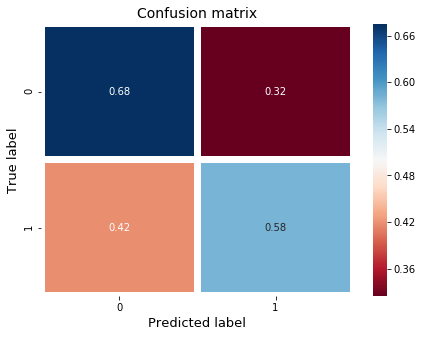

In [194]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix',fontsize = 14)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

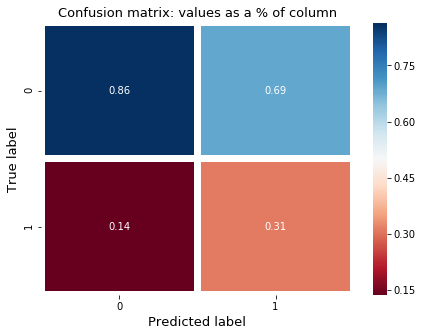

In [195]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

In [196]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, log_reg2.best_estimator_.predict_proba(X_test)[:,1])

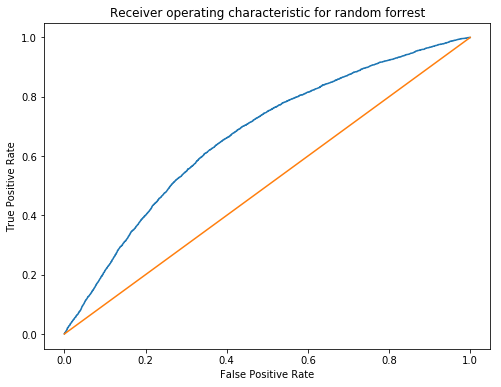

In [197]:
fig, ax =  plt.subplots(figsize = (8,6))
ax.plot(fpr,tpr)
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic for random forrest')
ax.legend(loc="lower right")
plt.show()


#### Conclusion logistic regression with oversampling:
We can see huge prediction improvement. Recall at the level of 58.1% on the test set means that we are able to predict almost 60% of all true positives. Precision at the level of 31.2% means that out of approx. 3 predicted positives one is true and two ale false positives.<br>
Although precision is a bit lower than in the model with under-represented class 0, recall is much higher. This model is helpful in solving the problem that is stated at the beginning of this notebook: now we are able to detect 60% of true no-shows (assuming that we can generalize basing on this sample data). It is of course worth noticing that precision is low, so there were quite many false positives, but in my opinion in this application, false positives are less of a problem than false negatives. 

### Random Forrest with oversampled class 0

In [199]:
tree2 = GridSearchCV(RandomForestClassifier(),
                                   param_grid = {'max_depth':[40,80,90],
                                                 'n_estimators':[10,30,40]},
                                   cv  = kflod_10,
                                   scoring = 'f1')
tree2.fit(X_train2,y_train2)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [40, 80, 90], 'n_estimators': [10, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [200]:
tree2.best_params_

{'max_depth': 90, 'n_estimators': 40}

In [201]:
'Best F-score for test set in crossvalidation: {:.3f}'.format(tree2.best_score_)

'Best F-score for test set in crossvalidation: 0.890'

#### Evaluation of model performance on test set

In [202]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test,tree2.best_estimator_.predict(X_test)))

'Precision: 34.3%'

In [203]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test,tree2.best_estimator_.predict(X_test)))

'Recall: 35.7%'

In [204]:
'Accuracy: {:.1%}'.format(metrics.accuracy_score(y_test,tree2.best_estimator_.predict(X_test)))

'Accuracy: 73.1%'

In [205]:
conf_tree = metrics.confusion_matrix(y_test,tree2.best_estimator_.predict(X_test))
pprint.pprint(conf_tree)

array([[18206,  3826],
       [ 3600,  1999]], dtype=int64)


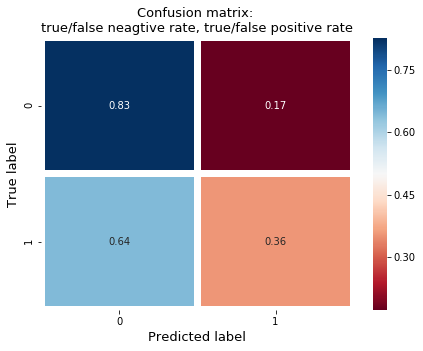

In [206]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_tree/np.sum(conf_tree,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: \ntrue/false neagtive rate, true/false positive rate',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

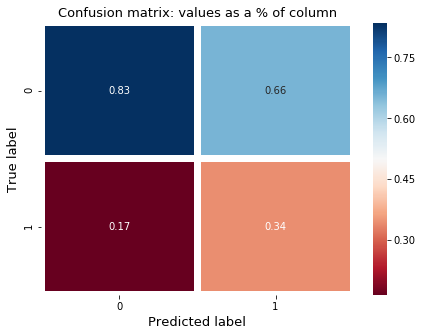

In [207]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_tree/np.sum(conf_tree,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

In [208]:
metrics.roc_auc_score(y_test,tree2.best_estimator_.predict_proba(X_test)[:,1])

0.69600409033385069

#### Analyse ROC curve

In [209]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree.best_estimator_.predict_proba(X_test)[:,1])

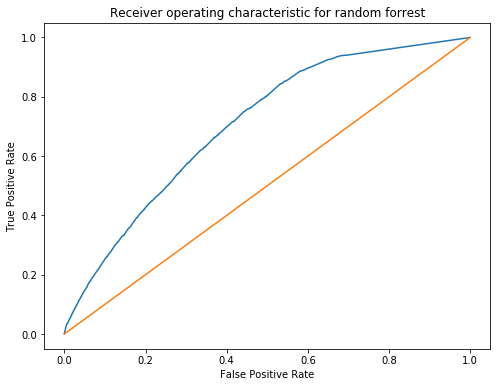

In [210]:
fig, ax =  plt.subplots(figsize = (8,6))
ax.plot(fpr,tpr)
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic for random forrest')
ax.legend(loc="lower right")
plt.show()


#### Conclusion Random Forrest with oversamples class 0:
The results are almost identical to Random Forrest model without oversampling.

#### Let's see the most important features as indicated by Random Forest Classifier.

In [211]:
Feature_importances = pd.Series()
for col, val in zip(X.columns,tree2.best_estimator_.feature_importances_):
    Feature_importances[col] = val

pd.options.display.float_format = '{:,.3f}'.format    
Feature_importances.sort_values(ascending = False)

Schedule_to_Appointment                     0.368
Age                                         0.340
Gender                                      0.027
SMS_received                                0.018
Hipertension                                0.012
Scholarship                                 0.008
Diabetes                                    0.008
Handcap                                     0.007
Alcoholism                                  0.005
Neighbourhood_RESISTÊNCIA                   0.005
Neighbourhood_CENTRO                        0.005
Neighbourhood_JARDIM CAMBURI                0.005
Neighbourhood_SÃO PEDRO                     0.005
Neighbourhood_SANTO ANTÔNIO                 0.005
Neighbourhood_BONFIM                        0.005
Neighbourhood_CARATOÍRA                     0.004
Neighbourhood_DA PENHA                      0.004
Neighbourhood_TABUAZEIRO                    0.004
Neighbourhood_ROMÃO                         0.004
Neighbourhood_MARIA ORTIZ                   0.004


-----------------------------------------------------------------------------------------------------------------------------

##  Grouping neighbourhood and oversampling
Let's see whether it will change the result of Logistic Regression:

In [212]:
X3 = Appointments_df.drop(['PatientId', 'AppointmentID', 'ScheduledDay','AppointmentDay','No-show','Neighbourhood'], axis=1)
X3['Neighbourhood_group'] = neighbourhood_cut.sort_index()

In [213]:
X3.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Schedule_to_Appointment,Neighbourhood_group
0,0,62,0,1,0,0,0,0,0,"(-0.001, 11.0]"
1,1,56,0,0,0,0,0,0,0,"(-0.001, 11.0]"
2,0,62,0,0,0,0,0,0,0,"(11.0, 25.0]"
3,0,8,0,0,0,0,0,0,0,"(11.0, 25.0]"
4,0,56,0,1,1,0,0,0,0,"(-0.001, 11.0]"


In [214]:
X3 = pd.get_dummies(X3)
X3.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Schedule_to_Appointment,"Neighbourhood_group_(-0.001, 11.0]","Neighbourhood_group_(11.0, 25.0]","Neighbourhood_group_(25.0, 36.0]","Neighbourhood_group_(36.0, 50.0]","Neighbourhood_group_(50.0, 63.0]","Neighbourhood_group_(63.0, 74.0]","Neighbourhood_group_(74.0, 77.0]","Neighbourhood_group_(77.0, 81.0]"
0,0,62,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0


In [215]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.25, random_state=10)

Oversampling (as the data without grouping):

In [216]:
X_train3 = pd.concat([X_train3.loc[idxs_zeros,:], X_train3.loc[ovrspl_idxes,:]], axis = 0)

In [217]:
y_train3 = y_train[X_train3.index]

In [218]:
log_reg3 = GridSearchCV(make_pipeline(preprocessing.StandardScaler(),LogisticRegression()),
                        param_grid = {'logisticregression__C':[0.01,0.1,1,5,10]},
                        cv  = kflod_10,
                        scoring = scoring,
                        refit = 'F1')

log_reg3.fit(X_train3,y_train3)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit='F1', return_train_score='warn',
       scoring={'F1': 'f1', 'ROC': 'roc_auc'}, verbose=0)

In [219]:
log_reg3.best_params_

{'logisticregression__C': 0.01}

In [220]:
log_reg3.best_score_

0.60081682883542076

In [221]:
'Precision: {:.1%}'.format(metrics.precision_score(y_test,log_reg3.best_estimator_.predict(X_test3)))

'Precision: 31.4%'

In [222]:
'Recall: {:.1%}'.format(metrics.recall_score(y_test,log_reg3.best_estimator_.predict(X_test3)))

'Recall: 56.8%'

In [223]:
conf_logreg = metrics.confusion_matrix(y_test,log_reg3.best_estimator_.predict(X_test3))
pprint.pprint(conf_logreg)

array([[15081,  6951],
       [ 2420,  3179]], dtype=int64)


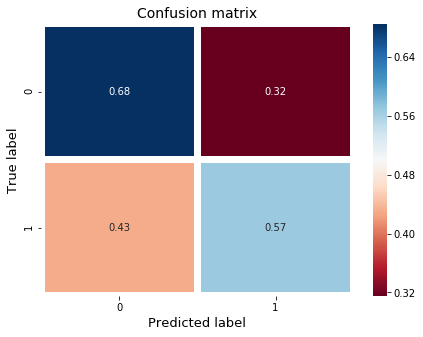

In [224]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=1).reshape(-1,1),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix',fontsize = 14)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

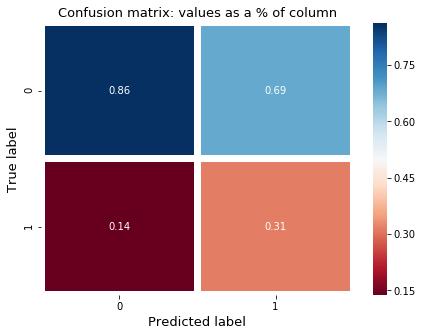

In [225]:
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(conf_logreg/np.sum(conf_logreg,axis=0),annot=True, linewidths=6,cmap = 'RdBu', ax =ax)
ax.set_title('Confusion matrix: values as a % of column',fontsize = 13)
ax.set_ylabel('True label',fontsize = 13)
ax.set_xlabel('Predicted label',fontsize = 13)
plt.show()#matrix with true positive rate, false positive rate etc.

#### Conclusion Logistic Regression with oversampled class 0 and grouped data: 
Grouping neighbourhood does not improve model performance.

## Summary:


Medical Appointment No Shows dataset containes data on patients and their appointments, where target value is whether patient came to visit or missed it. The goal of this project was to explore most important features for no-shows and build a model to predict no-shows.

I have started with exploratory data analysis of the no-show dataset (source: Kaggle). It came out that target variable is imbalanced: 80% of observations belong to class 0 (show) and only 20% to class 1 (no-show). Other of the most important conclusions from EDA are:

* Age is important factor differenciating no-show and show patients. The relationship is not linear - adolescent came to visit most often (we can assume that their parents care for it more than for their own visits), young adult have highest no-show ratio and older people tend to show up to their visits most often.


* Time from schedule to appointment is also of high importance when looking at no-show vs. show patients. The longer the time to appointment the higher is no-show ratio. This is very valuable information, because it suggests that preparing some system with reminders about appointments could have solved this issue. 


* Other features (like chronical diesease, handicap, etc.) also played some role, but not as important as two above: more info inside notebook. 

When it comes to model 3 approaches have been presented:

1) Using Random Forrest, Logistic Regression and SVC on all features (with binarization of neighbourhoods feature) with imbalanced target feature. Under this approach Random Forrest did best job (using f1 score or recall as a scoring metric), while Logistic Regression and SVC preformed poorly (they were very close to dummy classifier, which predicts class 0 only)

2) Using Random Forrest and Logistic Regression on all features (with binarization of neighbourhoods feature) and oversampling under-represented class (in this case class 1 - no-show). After oversampling procedure the results of Random Forrest remained very simmilar, but performance of Logistic Regression improved significantly (f1 score on the level of 0.6 for best score in crossvalidation). At the same token this model gave the best results when detecting true positives.

3) Using Logisitc Regression with neighbourhood feature grouped (using thresholds from decision tree) and oversampling under-represented class. Grouping neighbourhood feature did not change the model performace.

